In [1]:
### Importing Modules
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn import metrics

In [2]:
#Importing Datasets
Transaction_Info=pd.read_csv("data-new/transactions_obf.csv")
Reported_Frauds=pd.read_csv("data-new/labels_obf.csv")
Transaction_Info['merchantCountry']

0         826
1         826
2         442
3         826
4         826
         ... 
118616    826
118617    826
118618    826
118619    826
118620    826
Name: merchantCountry, Length: 118621, dtype: int64

In [3]:
#Splitting Date/Time Feature
Transaction_Info["transactionDate"]=pd.to_datetime(Transaction_Info["transactionTime"]).dt.date
Transaction_Info["transactionTime"]=pd.to_datetime(Transaction_Info["transactionTime"]).dt.time
DateSplit=pd.DataFrame([str(i).split('-') for i in Transaction_Info.transactionDate],columns=['transactionYear','transactionMonth','transactionDay'])
TimeSplit=pd.DataFrame([str(i).split(':')[0:3] for i in Transaction_Info.transactionTime],columns=['transactionHour','transactionMinute','transactionSecond'])
Transaction_Info[['transactionHour','transactionMinute','transactionSecond']]=TimeSplit.astype(int)
Transaction_Info[['transactionYear','transactionMonth','transactionDay']]=DateSplit.astype(int)
Transaction_Info

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,transactionDate,transactionHour,transactionMinute,transactionSecond,transactionYear,transactionMonth,transactionDay
0,00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,2017-01-01,0,0,0,2017,1,1
1,00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,2017-01-01,0,49,3,2017,1,1
2,00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,2017-01-01,0,43,17,2017,1,1
3,00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,2017-01-01,0,15,7,2017,1,1
4,00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,2017-01-01,0,37,9,2017,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,23:52:16,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,2018-01-30,23,52,16,2018,1,30
118617,23:57:16,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,2018-01-30,23,57,16,2018,1,30
118618,23:59:03,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,2018-01-30,23,59,3,2018,1,30
118619,00:04:44,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,2018-01-31,0,4,44,2018,1,31


In [4]:
#Defining Fraud Labels
Transaction_Info['fraudLabel']=False
for i in Reported_Frauds.eventId:
    Transaction_Info.loc[Transaction_Info.eventId==i,'fraudLabel']=True

In [5]:
#Cleaning Data off of missing and noisy values
Transaction_Info=Transaction_Info[Transaction_Info.posEntryMode!=79]
Transaction_Info=Transaction_Info[Transaction_Info.transactionAmount>0]
Transaction_Info.iloc[Transaction_Info.merchantZip.isnull(),6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="..",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="...",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="....",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip==".....",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="**",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="***",6]='0'

In [6]:
#Reseting Index after cleaning
Transaction_Info=Transaction_Info.reset_index()
del Transaction_Info['index']

In [7]:
#All Categorical Features
Transaction_Info['merchantZip'].unique()
Transaction_Info['posEntryMode'].unique()
Transaction_Info['mcc'].unique()
Transaction_Info['merchantCountry'].unique()
Transaction_Info['merchantZip'].unique()

array(['CR0', 'DE14', '0', ..., 'E16HU', 'M45JU', 'W84PT'], dtype=object)

In [8]:
# for i in range(len(Transaction_Info)):
#     temporary=Transaction_Info.iloc[0:i+1,[2,11]]
#     anothertemporary=temporary[temporary.accountNumber==list(temporary.accountNumber)[-1]]
#     Transaction_Info.iloc[i,13]=len(anothertemporary[anothertemporary.fraudLabel==1])
#     del temporary,anothertemporary

#     print((i/118621)*100,"%/ rewritten")
# for i in range(len(Transaction_Info)):
#     temporary=Transaction_Info.iloc[0:i+1,[3,11]]
#     anothertemporary=temporary[temporary.merchantId==list(temporary.merchantId)[-1]]
#     Transaction_Info.iloc[i,12]=len(anothertemporary[anothertemporary.fraudLabel==1])
#     del temporary,anothertemporary
#     print((i/118621)*100,"%/ rewritten")


In [9]:
#Converting Categorical Data to Numeric Data
AccountNumberCategories=pd.Categorical(Transaction_Info.accountNumber)
MerchantIdCategories=pd.Categorical(Transaction_Info.accountNumber)
MerchantZip=pd.Categorical(Transaction_Info.merchantZip)
Transaction_Info['accountNumberCodes']=AccountNumberCategories.codes
Transaction_Info['merchantIdCodes']=MerchantIdCategories.codes
Transaction_Info['MerchantZipCodes']=MerchantZip.codes

In [10]:
Transaction_Info["fraudLabel"].unique()

array([False,  True])

In [11]:
# Splitting Dataset into False and True Test/Train Sets
TrueTrainCases=Transaction_Info[Transaction_Info.fraudLabel==True].sample(800)
All_Other_True_Cases=pd.concat([Transaction_Info[Transaction_Info.fraudLabel==True],TrueTrainCases]).drop_duplicates(keep=False)#Transaction_Info-TrueTrainCases
TrueTestCases=pd.concat([All_Other_True_Cases,TrueTrainCases.sample(50)])
FalseTrainCases=Transaction_Info[Transaction_Info.fraudLabel==False].sample(1800)
FalseTestCases=pd.concat([Transaction_Info[Transaction_Info.fraudLabel==False],FalseTrainCases]).drop_duplicates(keep=False)#Transaction_Info-FalseTrainCases

In [12]:
#Features that contribute to the analysis
TrainingIndex=['mcc','posEntryMode','transactionAmount','availableCash','accountNumberCodes','merchantIdCodes','MerchantZipCodes','transactionHour','transactionMinute','transactionSecond','transactionYear','transactionMonth','transactionDay']
TheTrainData=pd.concat([TrueTrainCases,FalseTrainCases])[TrainingIndex+['fraudLabel']]

In [13]:
TheTrainData["fraudLabel"]

26220      True
78355      True
73253      True
21445      True
50020      True
          ...  
2074      False
109952    False
56415     False
15578     False
12052     False
Name: fraudLabel, Length: 2600, dtype: bool

In [14]:
#Defining the AI Model and  Gridsearch Parameters list 
n_estimators=[i for i in range(5,20,4)]
criterion=["gini", "entropy"]
max_depth=[i for i in range(5,25,4)]
min_samples_split=[i for i in range(5,30,4)]
min_samples_leaf=[i for i in range(3,10)]
max_features=['auto', 'sqrt']
bootstrap=[False]
Parameters= {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion':criterion
    }
#n_jobs=,random_state=,verbose=,warm_start=,class_weight=,max_samples=}
model=RandomForestClassifier()
random_model=GridSearchCV(estimator=model,param_grid=Parameters,verbose=4)


In [15]:
TheTrainData.fraudLabel

26220      True
78355      True
73253      True
21445      True
50020      True
          ...  
2074      False
109952    False
56415     False
15578     False
12052     False
Name: fraudLabel, Length: 2600, dtype: bool

In [16]:
#Fitting the model onto the Train Data  
random_model.fit(TheTrainData[TrainingIndex],TheTrainData['fraudLabel'])
print(random_model.best_params_)

Fitting 5 folds for each of 3920 candidates, totalling 19600 fits
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.831 total time=   0.0s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.827 total time=   0.0s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.827 total time=   0.0s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.827 total time=   0.0s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.850 total time=   0.0s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, m

In [17]:
#Preparing Test Data
TheTestData=pd.concat([TrueTestCases,FalseTestCases.sample(100)])[TrainingIndex+['fraudLabel']]

In [18]:
TheTestData.fraudLabel

14         True
735        True
8028       True
10163      True
11625      True
          ...  
87927     False
111956    False
19575     False
45785     False
76451     False
Name: fraudLabel, Length: 200, dtype: bool

0        True
1        True
2        True
3        True
4        True
        ...  
1595    False
1596    False
1597    False
1598    False
1599    False
Length: 1600, dtype: bool


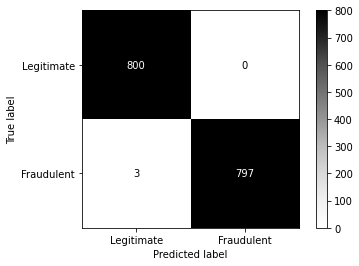

In [124]:
#Test Predictions

Testing_On_Train_Data=pd.concat([TrueTrainCases,FalseTrainCases.sample(800)])[TrainingIndex+['fraudLabel']]
Predictions=pd.Series(random_model.predict(Testing_On_Train_Data[TrainingIndex]))
Results=Testing_On_Train_Data.fraudLabel;    Results=Results.reset_index().fraudLabel
print(Predictions)

#Performance of the Classifier on Training Data
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(Results),list(Predictions)),display_labels=["Legitimate","Fraudulent"]).plot(cmap='Greys')

0      False
1       True
2      False
3      False
4      False
       ...  
195    False
196    False
197    False
198    False
199    False
Length: 200, dtype: bool


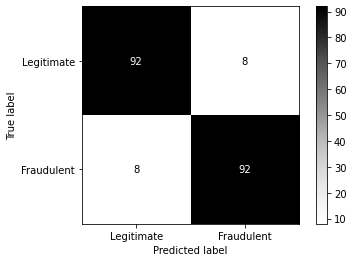

In [125]:
#Test Predictions
Predictions=pd.Series(random_model.predict(TheTestData[TrainingIndex]))
Results=TheTestData.fraudLabel;    Results=Results.reset_index().fraudLabel
print(Predictions)


#Performance of the Classifier on Test Data
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(Results),list(Predictions)),display_labels=["Legitimate","Fraudulent"]).plot(cmap='Greys')

In [126]:
print(random_model.score(Testing_On_Train_Data[TrainingIndex],Testing_On_Train_Data.fraudLabel))
print(random_model.score(TheTestData[TrainingIndex],TheTestData.fraudLabel))

0.998125
0.92


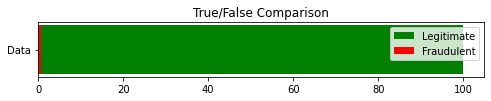

In [127]:
weight_counts = {
    'Legitimate':[sum(Transaction_Info.fraudLabel==False)*100/len(Transaction_Info)],
    'Fraudulent':[sum(Transaction_Info.fraudLabel==True)*100/len(Transaction_Info)]
}

fig, ax = plt.subplots(figsize=(8,1))
ax.barh('Data',weight_counts['Legitimate'],label='Legitimate',left=weight_counts['Fraudulent'],color='green')

ax.barh('Data',weight_counts['Fraudulent'],label='Fraudulent',left=0,color='red')

ax.set_title("True/False Comparison")
ax.legend(loc="upper right")

plt.show()